In [1]:
%matplotlib inline
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pylab import cm

from shapely.geometry import Point

from esda.getisord import G_Local
from esda.moran import Moran
from libpysal.weights import KNN

from tqdm.auto import tqdm
import random
import mapclassify
from collections import Counter
import statsmodels.formula.api as smf

<h3> Different skills used for 7 questions explored </h3>
<p>Combines 2 or more data frames: 6/7</p>
<p>Used 5 different datasets</p>
<ol>
  <li>Use of groupby and aggregate functions: 5/7</li>
  <li>Spatial analysis requiring sjoin: 5/7</li>
  <li>Spatial analysis requiring local or global autocorrelation: 4/7</li>
  <li>Linear regression analysis involving more than 5 independent variables: 3/7</li>
</ol>




In [2]:
# Setup
# 5 different datasets used

detroit_incidents=pd.read_csv('Detroit-RMS_Crime_Incidents.csv', dtype={'arrest_charge':'str', 'scout_car_area':'str','precinct':'str'})
scout_car_map = gpd.read_file('DPD_Scout_Car_Areas/DPD_SCAs.shp')
neighborhood_map= gpd.read_file('theNeighborhoods/theNeighborhoods.shp')
police_precincts_map = gpd.read_file('DPD_Police_Precincts/DPD_Police_Precincts.shp')
projection = "+proj=laea +lat_0=30 +lon_0=-95"
scout_car_map = scout_car_map.to_crs(projection)
neighborhood_map = neighborhood_map.to_crs(projection)
police_precincts_map = police_precincts_map.to_crs(projection)
detroit_incidents = gpd.GeoDataFrame(detroit_incidents, geometry=gpd.points_from_xy(detroit_incidents.longitude,detroit_incidents.latitude))
detroit_incidents.crs = "EPSG:4326"
detroit_incidents = detroit_incidents.to_crs(projection)
race_map= gpd.read_file('DetroitCrimeRace/race.shp')
race_map= race_map.to_crs(projection)

[None, None, None, None, None, None, None, None, None, None, None, None]

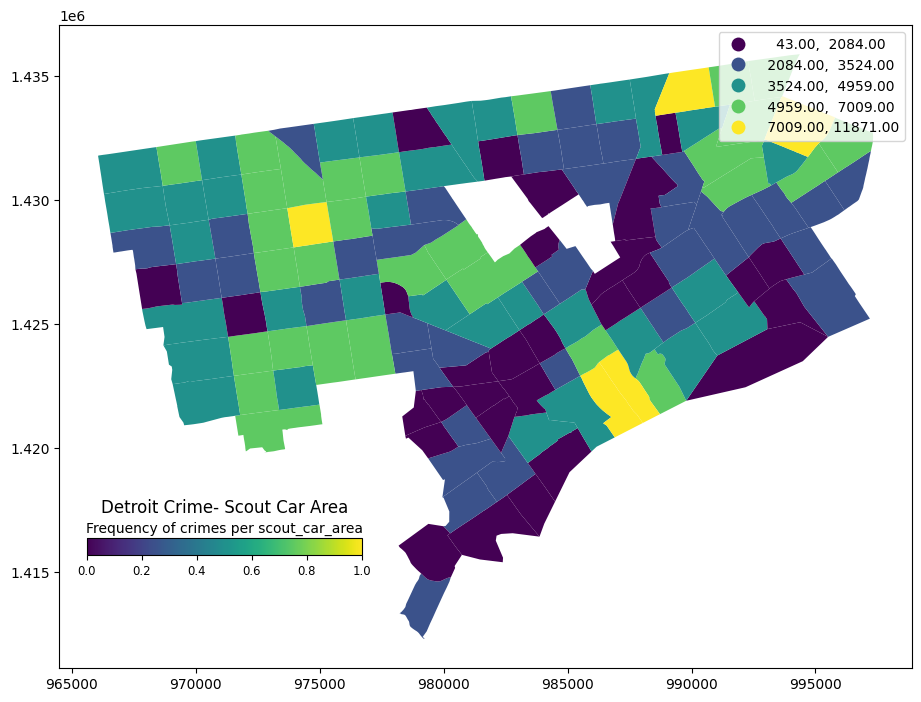

In [3]:
# Question 1: Does crime rate tend to follow regional patterns, with it being clustered more in specific scout car areas?
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes
scout_incidents = gpd.sjoin(scout_car_map, detroit_incidents, how='inner', predicate='contains')
fidCount=scout_incidents.groupby('FID')['scout_car_area'].apply(lambda x: x.count()).to_frame()
fidCount.columns=['FID_Count']
fidCount=fidCount.merge(scout_car_map[['geometry','FID']], left_index=True,right_on='FID',how='right')
fidCount.set_index('FID', inplace=True)
fidCount = gpd.GeoDataFrame(fidCount, geometry=fidCount['geometry'])
fidCount['FID_Count']=fidCount['FID_Count'].fillna(0)
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
fidCount.plot(ax=ax, column='FID_Count',scheme='fisher_jenks',legend=True)
cbax = figZ.add_axes([0.15, 0.25, 0.25, 0.02])
cb2 = mpl.colorbar.ColorbarBase(cbax, orientation='horizontal')
cb2.set_label(r'Frequency of crimes per scout_car_area')
cb2.ax.xaxis.set_label_position('top')
cb2.ax.xaxis.label.set_multialignment('center')
plt.title("Detroit Crime- Scout Car Area")
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

In [4]:
listws25 = KNN.from_dataframe(fidCount, k=25)
mi = Moran(fidCount['FID_Count'], listws25)
print("Moran's I for relationship between crime rate and scout_car_area:", mi.I) 
print("Moran's p-value (under normality assumption) for relationship between crime rate and scout_car_area: %0.19f" % mi.p_norm) 

Moran's I for relationship between crime rate and scout_car_area: 0.1116457434538516
Moran's p-value (under normality assumption) for relationship between crime rate and scout_car_area: 0.0000000126629711161


[None, None, None, None, None, None, None, None, None, None, None, None]

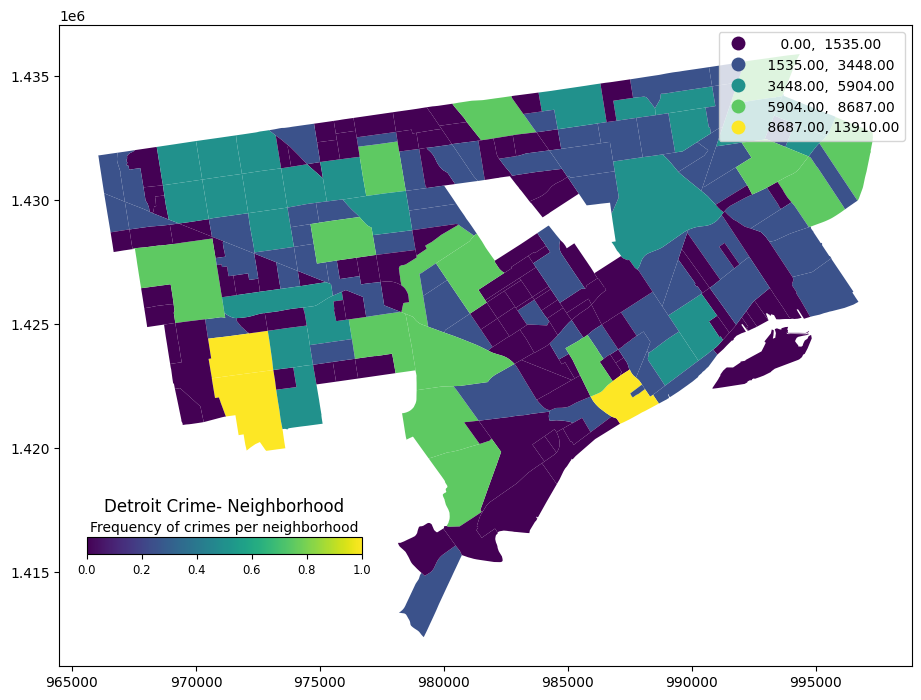

In [5]:
# Question 2: Does crime rate tend to follow regional patterns, with it being clustered more in specific neighborhoods?
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes

neighborhood_incidents = gpd.sjoin(neighborhood_map, detroit_incidents, how='inner', predicate='contains')
neighCount=neighborhood_incidents.groupby('neighborhood')['neighborhood'].apply(lambda x: x.count()).to_frame()
neighCount.columns=['Neigh_Count']
neighCount=neighCount.merge(neighborhood_map[['geometry','name']], left_index=True,right_on='name',how='right')
neighCount.set_index('name', inplace=True)
neighCount = gpd.GeoDataFrame(neighCount, geometry=neighCount['geometry'])
neighCount['Neigh_Count']=neighCount['Neigh_Count'].fillna(0)
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
neighCount.plot(ax=ax, column='Neigh_Count',scheme='fisher_jenks',legend=True)
cbax = figZ.add_axes([0.15, 0.25, 0.25, 0.02])
cb2 = mpl.colorbar.ColorbarBase(cbax, orientation='horizontal')
cb2.set_label(r'Frequency of crimes per neighborhood')
cb2.ax.xaxis.set_label_position('top')
cb2.ax.xaxis.label.set_multialignment('center')
plt.title("Detroit Crime- Neighborhood")
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

In [6]:
neighCount.reset_index(inplace=True)
listws25 = KNN.from_dataframe(neighCount, k=25)
mi = Moran(neighCount['Neigh_Count'], listws25)
print("Moran's I for relationship between crime rate and neighborhoods:", mi.I) 
print("Moran's p-value (under normality assumption) for relationship between crime rate and neigborhood: %0.19f" % mi.p_norm) 

Moran's I for relationship between crime rate and neighborhoods: 0.04688727373214758
Moran's p-value (under normality assumption) for relationship between crime rate and neigborhood: 0.0030242372509110549


[None, None, None, None, None, None, None, None, None, None, None, None]

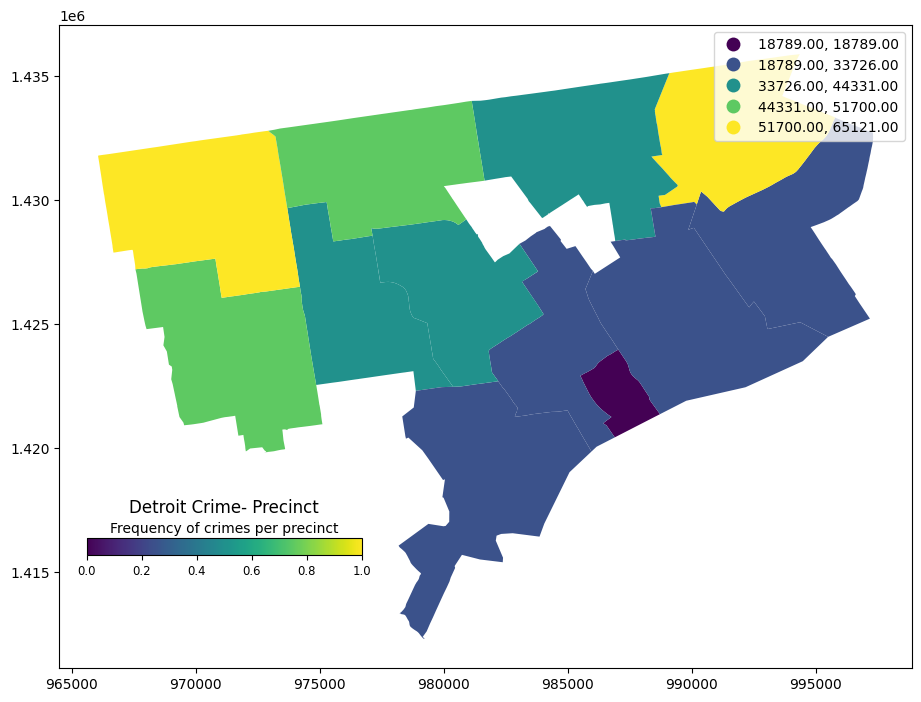

In [7]:
# Question 3: Does crime rate tend to follow regional patterns, with it being clustered more in specific precincts?
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes
precinct_incidents = gpd.sjoin(police_precincts_map, detroit_incidents, how='inner', predicate='contains')
precCount=precinct_incidents.groupby('Precinct')['Precinct'].apply(lambda x: x.count()).to_frame()
precCount.columns=['Prec_Count']
precCount=precCount.merge(police_precincts_map[['geometry','Precinct']], left_index=True,right_on='Precinct',how='right')
precCount.set_index('Precinct', inplace=True)
precCount = gpd.GeoDataFrame(precCount, geometry=precCount['geometry'])
precCount['Prec_Count']=precCount['Prec_Count'].fillna(0)
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
precCount.plot(ax=ax, column='Prec_Count',scheme='fisher_jenks',legend=True)
cbax = figZ.add_axes([0.15, 0.25, 0.25, 0.02])
cb2 = mpl.colorbar.ColorbarBase(cbax, orientation='horizontal')
cb2.set_label(r'Frequency of crimes per precinct')
cb2.ax.xaxis.set_label_position('top')
cb2.ax.xaxis.label.set_multialignment('center')
plt.title("Detroit Crime- Precinct")
plt.setp(plt.getp(cb2.ax.axes, 'xticklabels'), fontsize='small')

In [8]:
listws25 = KNN.from_dataframe(precCount, k=11)
mi = Moran(precCount['Prec_Count'], listws25)
print("Moran's I for relationship between crime rate and precincts:", mi.I) 
print("Moran's p-value (under normality assumption) for relationship between crime rate and precinct: %0.19f" % mi.p_norm) 

Moran's I for relationship between crime rate and precincts: -0.0909090909090909
Moran's p-value (under normality assumption) for relationship between crime rate and precinct: 0.9999999940552968258


In [9]:
# Question 4: Are parks and homes in detroit spatially auto correlated?
# Spatial analysis requiring local or global autocorrelation
# Combines 2 or more dataframes
neighCountPH=neighCount.merge(neighborhood_map[['parks','homes','name']], left_on='name',right_on='name',how='right')
neighCountPH = gpd.GeoDataFrame(neighCountPH, geometry=neighCountPH['geometry'])
neighCountPH['parks']=neighCountPH['parks'].fillna(0)
neighCountPH['homes']=neighCountPH['homes'].fillna(0)
listws25 = KNN.from_dataframe(neighCountPH, k=25)
mi = Moran(neighCountPH['parks'], listws25)
print("Moran's I for parks:", mi.I) 
print("Moran's p-value (under normality assumption) for parks: %0.19f" % mi.p_norm) 


Moran's I for parks: 0.10097910213911113
Moran's p-value (under normality assumption) for parks: 0.0000000011992706828


In [10]:
neighCountPH['homes']=neighCountPH['homes'].fillna(0)
mi = Moran(neighCountPH['homes'], listws25)
print("Moran's I for homes:", mi.I) 
print("Moran's p-value (under normality assumption) for homes: %0.19f" % mi.p_norm) 

Moran's I for homes: 0.14390305379234442
Moran's p-value (under normality assumption) for homes: 0.0000000000000000000


In [11]:
# Question 5: Is there a correlation between homes, hour of day, and day of week in relation to zip_code, scout_car_area, neighborhood, council_district, and precinct?
# Linear regression analysis involving more than 5 independent variables

model = smf.ols('homes ~ C(zip_code) + C(scout_car_area) + C(neighborhood) + C(council_district) + C(precinct)', data=neighborhood_incidents)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  homes   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 1.323e+04
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:44:13   Log-Likelihood:            -3.7606e+06
No. Observations:              492711   AIC:                         7.522e+06
Df Residuals:                  492325   BIC:                         7.526e+06
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                      2272.9661     58.193     39.059      0.000    2158.909    2387.023
C(zip_code)[T.48202]                            131.2864     20.130      6.522      0.000      91.833     170.740
C(zip_code)[T.48203]                           -185.6892     28.084     -6.612      0.000    -240.732    -130.646
C(zip_code)[T.48204]                           -130.7910     22.493     -5.815      0.000    -174.876     -86.706
C(zip_code)[T.48205]                           -102.6391     25.202     -4.073      0.000    -152.033     -53.245
C(zip_code)[T.48206]                            249.3509     21.498     11.599      0.000     207.216     291.486
C(zip_code)[T.48207]                            -40.1837     18.649     -2.155      0.031     -76.736      -3.632
C(zip_code)[T.48208]                             62.5853     19.104      3.276      0.001      25.142     100.028
C(zip_code)[T.48209]                             36.7296     26.084      1.408      0.159     -14.394      87.853
C(zip_code)[T.48210]                            -40.6774     24.985     -1.628      0.104     -89.646       8.292
C(zip_code)[T.48211]                            131.4393     22.246      5.908      0.000      87.837     175.041
C(zip_code)[T.48212]                           -262.5173     29.226     -8.982      0.000    -319.799    -205.235
C(zip_code)[T.48213]                            -49.0445     23.444     -2.092      0.036     -94.993      -3.096
C(zip_code)[T.48214]                           -116.2465     22.551     -5.155      0.000    -160.445     -72.048
C(zip_code)[T.48215]                           -138.6836     29.856     -4.645      0.000    -197.201     -80.166
C(zip_code)[T.48216]                            -49.0840     20.668     -2.375      0.018     -89.593      -8.575
C(zip_code)[T.48217]                          -1296.4499    194.689     -6.659      0.000   -1678.034    -914.865
C(zip_code)[T.48219]                           -165.2313     34.664     -4.767      0.000    -233.171     -97.292
C(zip_code)[T.48221]                           -223.3445     24.503     -9.115      0.000    -271.370    -175.319
C(zip_code)[T.48223]                            -82.8435     30.165     -2.746      0.006    -141.966     -23.721
C(zip_code)[T.48224]                             22.2283     28.002      0.794      0.427     -32.655      77.111
C(zip_code)[T.48226]                            -42.6777     21.357     -1.998      0.046     -84.537      -0.818
C(zip_code)[T.48227]                           -249.4923     23.604    -10.570      0.000    -295.756    -203.228
C(zip_code)[T.48228]                           -169.3985     24.981     -6.781      0.000    -218.361    -120.436
C(zip

In [12]:
model = smf.ols('hour_of_day ~ C(zip_code) + C(scout_car_area) + C(neighborhood) + C(council_district) + C(precinct)', data=neighborhood_incidents)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hour_of_day   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     6.664
Date:                Tue, 04 Apr 2023   Prob (F-statistic):          6.00e-317
Time:                        22:44:51   Log-Likelihood:            -1.6930e+06
No. Observations:              492711   AIC:                         3.387e+06
Df Residuals:                  492325   BIC:                         3.391e+06
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        13.6007      0.876     15.530      0.000      11.884      15.317
C(zip_code)[T.48202]                             -0.6902      0.303     -2.278      0.023      -1.284      -0.096
C(zip_code)[T.48203]                             -1.3993      0.423     -3.311      0.001      -2.228      -0.571
C(zip_code)[T.48204]                             -1.3639      0.339     -4.029      0.000      -2.027      -0.700
C(zip_code)[T.48205]                             -0.7712      0.379     -2.033      0.042      -1.515      -0.028
C(zip_code)[T.48206]                             -1.2897      0.324     -3.986      0.000      -1.924      -0.656
C(zip_code)[T.48207]                             -0.1538      0.281     -0.548      0.584      -0.704       0.396
C(zip_code)[T.48208]                             -0.5217      0.288     -1.814      0.070      -1.085       0.042
C(zip_code)[T.48209]                             -0.2486      0.393     -0.633      0.527      -1.018       0.521
C(zip_code)[T.48210]                             -1.1210      0.376     -2.981      0.003      -1.858      -0.384
C(zip_code)[T.48211]                             -0.7175      0.335     -2.143      0.032      -1.374      -0.061
C(zip_code)[T.48212]                             -0.9258      0.440     -2.105      0.035      -1.788      -0.064
C(zip_code)[T.48213]                             -0.6819      0.353     -1.933      0.053      -1.373       0.010
C(zip_code)[T.48214]                             -0.8239      0.339     -2.428      0.015      -1.489      -0.159
C(zip_code)[T.48215]                             -0.4484      0.449     -0.998      0.318      -1.329       0.432
C(zip_code)[T.48216]                             -0.7742      0.311     -2.489      0.013      -1.384      -0.165
C(zip_code)[T.48217]                              1.7216      2.930      0.588      0.557      -4.021       7.464
C(zip_code)[T.48219]                             -1.1057      0.522     -2.120      0.034      -2.128      -0.083
C(zip_code)[T.48221]                             -1.5795      0.369     -4.283      0.000      -2.302      -0.857
C(zip_code)[T.48223]                             -1.1699      0.454     -2.577      0.010      -2.060      -0.280
C(zip_code)[T.48224]                             -0.7527      0.421     -1.786      0.074      -1.579       0.073
C(zip_code)[T.48226]                             -0.7404      0.321     -2.303      0.021      -1.370      -0.110
C(zip_code)[T.48227]                             -1.4887      0.355     -4.191      0.000      -2.185      -0.792
C(zip_code)[T.48228]                             -1.3550      0.376     -3.604      0.000      -2.092      -0.618
C(zip

In [13]:
model = smf.ols('day_of_week ~ C(zip_code) + C(scout_car_area) + C(neighborhood) + C(council_district) + C(precinct)', data=neighborhood_incidents)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            day_of_week   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.360
Date:                Tue, 04 Apr 2023   Prob (F-statistic):          1.94e-226
Time:                        22:45:29   Log-Likelihood:            -1.0390e+06
No. Observations:              492711   AIC:                         2.079e+06
Df Residuals:                  492325   BIC:                         2.083e+06
Df Model:                         385                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         4.4328      0.232     19.087      0.000       3.978       4.888
C(zip_code)[T.48202]                             -0.1822      0.080     -2.268      0.023      -0.340      -0.025
C(zip_code)[T.48203]                             -0.2067      0.112     -1.844      0.065      -0.426       0.013
C(zip_code)[T.48204]                             -0.1450      0.090     -1.615      0.106      -0.321       0.031
C(zip_code)[T.48205]                             -0.1804      0.101     -1.794      0.073      -0.378       0.017
C(zip_code)[T.48206]                             -0.0853      0.086     -0.995      0.320      -0.253       0.083
C(zip_code)[T.48207]                             -0.1383      0.074     -1.858      0.063      -0.284       0.008
C(zip_code)[T.48208]                             -0.1416      0.076     -1.857      0.063      -0.291       0.008
C(zip_code)[T.48209]                             -0.2106      0.104     -2.023      0.043      -0.415      -0.007
C(zip_code)[T.48210]                             -0.0789      0.100     -0.791      0.429      -0.274       0.117
C(zip_code)[T.48211]                             -0.2336      0.089     -2.631      0.009      -0.408      -0.060
C(zip_code)[T.48212]                             -0.0219      0.117     -0.188      0.851      -0.250       0.207
C(zip_code)[T.48213]                             -0.1449      0.094     -1.549      0.121      -0.328       0.038
C(zip_code)[T.48214]                             -0.1274      0.090     -1.415      0.157      -0.304       0.049
C(zip_code)[T.48215]                             -0.1991      0.119     -1.671      0.095      -0.433       0.034
C(zip_code)[T.48216]                             -0.1623      0.082     -1.967      0.049      -0.324      -0.001
C(zip_code)[T.48217]                             -0.9373      0.777     -1.206      0.228      -2.460       0.586
C(zip_code)[T.48219]                              0.0525      0.138      0.380      0.704      -0.219       0.324
C(zip_code)[T.48221]                             -0.1379      0.098     -1.410      0.159      -0.330       0.054
C(zip_code)[T.48223]                             -0.0978      0.120     -0.812      0.417      -0.334       0.138
C(zip_code)[T.48224]                             -0.1747      0.112     -1.564      0.118      -0.394       0.044
C(zip_code)[T.48226]                             -0.2088      0.085     -2.450      0.014      -0.376      -0.042
C(zip_code)[T.48227]                             -0.1447      0.094     -1.536      0.125      -0.329       0.040
C(zip_code)[T.48228]                             -0.3049      0.100     -3.058      0.002      -0.500      -0.109
C(zip

Text(0.5, 1.0, 'Largest Racial Demographic per Region in Detroit')

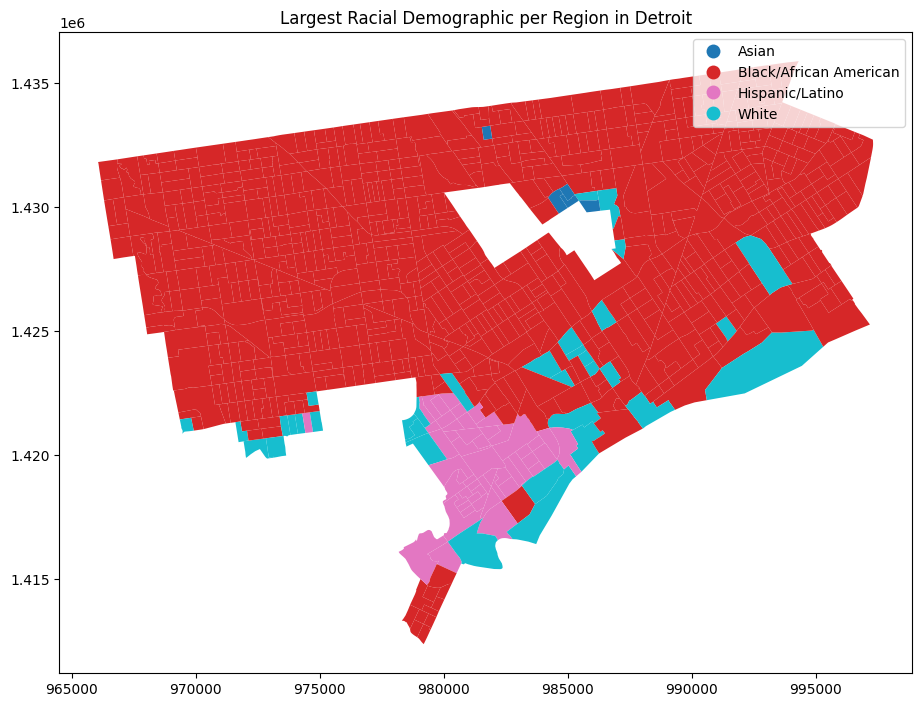

In [14]:
# Question #6: What is the largest racial demographic per regions in Detroit, and is there a bias in the data when identifying a trend between racial population in neighborhoods for certain races more than others??
# Combines 2 or more data frames
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
# Linear regression analysis involving more than 5 independent variables

race_map['RaceEthnic'].replace('Asian alone','Asian',inplace=True)
race_map['RaceEthnic'].replace('Black or African American alone','Black/African American',inplace=True)
race_map['RaceEthnic'].replace('Hispanic or Latino:','Hispanic/Latino',inplace=True)
race_map['RaceEthnic'].replace('White alone','White',inplace=True)
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
race_map.plot(column='RaceEthnic', ax=ax,legend=True)
plt.title("Largest Racial Demographic per Region in Detroit")

Text(0.5, 1.0, 'Population in Detroit')

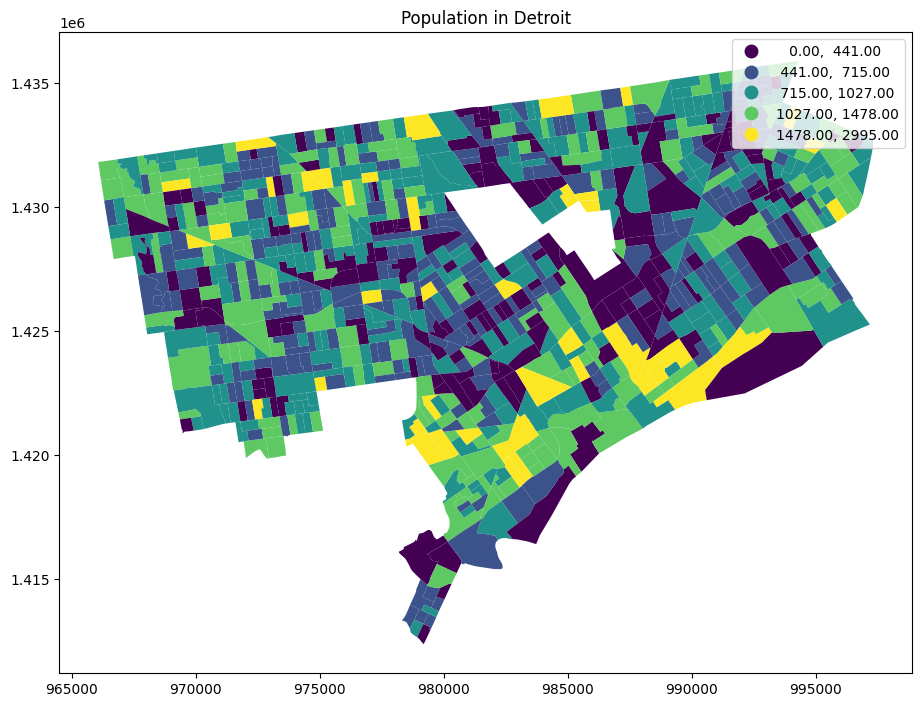

In [15]:
figZ, ax = plt.subplots(1, figsize=(11,8.5))
ax.axis('on')
race_map.plot(ax=ax, column='B03002_001', legend=True,scheme='fisher_jenks')
plt.title("Population in Detroit")

In [16]:
race_incidents = gpd.sjoin(neighborhood_incidents.drop(columns='index_right'), race_map, how='inner', predicate='contains')

In [17]:
areas=race_incidents.groupby('name')
area_names= race_incidents['name'].drop_duplicates().to_frame()
area_names.reset_index(drop=True,inplace=True)
crimeCountPerArea=areas['name'].apply(lambda x: x.count()).to_frame()
crimeCountPerArea.reset_index(drop=True,inplace=True)
totalPerArea=areas['B03002_001'].apply(lambda x: x.sum()).to_frame()
totalPerArea.reset_index(drop=True,inplace=True)
africanAmericansPerArea=areas['AA'].apply(lambda x: x.sum()).to_frame()
africanAmericansPerArea.reset_index(drop=True,inplace=True)
asianPerArea=areas['Asian'].apply(lambda x: x.sum()).to_frame()
asianPerArea.reset_index(drop=True,inplace=True)
whitePerArea=areas['White'].apply(lambda x: x.sum()).to_frame()
whitePerArea.reset_index(drop=True,inplace=True)
hispanicPerArea=areas['Hispanic'].apply(lambda x: x.sum()).to_frame()
hispanicPerArea.reset_index(drop=True,inplace=True)
neighborhood_race= pd.concat([area_names,crimeCountPerArea, totalPerArea, africanAmericansPerArea,whitePerArea,hispanicPerArea,asianPerArea],axis=1)
neighborhood_race.columns=['Neighborhood_Name', 'Crime_Count', 'Total_Count', 'AA_Count', 'White_Count', 'Hispanic_Count', 'Asian_Count']


In [18]:
model = smf.ols('Crime_Count ~ Total_Count + AA_Count + White_Count + Hispanic_Count + Asian_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     182.0
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           2.16e-39
Time:                        22:45:42   Log-Likelihood:                -794.83
No. Observations:                  78   AIC:                             1602.
Df Residuals:                      72   BIC:                             1616.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        239.1074   1005.344      0.238      0.813   -1765.009    2243.223
Total_Count       -0.0031      0.003     -1.221      0.226      -0.008       0.002
AA_Count           0.0047      0.003      1.771      0.081      -0.001       0.010
White_Count        0.0042      0.003      1.562      0.123      -0.001       0.010
Hispanic_Count     0.0040      0.003      1.536      0.129      -0.001       0.009
Asian_Count        0.0026      0.003      0.837      0.405      -0.004       0.009
==============================================================================
Omnibus:                       21.967   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.840
Skew:                           1.004   Prob(JB):                     8.21e-10
Kurtosis:                       5.974   Cond. No.                     3.88e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.88e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
model = smf.ols('Crime_Count ~ AA_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     236.4
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           4.90e-25
Time:                        22:45:42   Log-Likelihood:                -841.60
No. Observations:                  78   AIC:                             1687.
Df Residuals:                      76   BIC:                             1692.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2913.0291   1713.864      1.700      0.093    -500.426    6326.485
AA_Count       0.0015   9.74e-05     15.376      0.000       0.001       0.002
==============================================================================
Omnibus:                       71.196   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.573
Skew:                           2.829   Prob(JB):                    3.97e-103
Kurtosis:                      13.634   Cond. No.                     2.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
model = smf.ols('Crime_Count ~ White_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     26.92
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           1.71e-06
Time:                        22:45:42   Log-Likelihood:                -884.91
No. Observations:                  78   AIC:                             1774.
Df Residuals:                      76   BIC:                             1779.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.486e+04   2491.755      5.964      0.000    9897.839    1.98e+04
White_Count     0.0030      0.001      5.188      0.000       0.002       0.004
==============================================================================
Omnibus:                       24.143   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.378
Skew:                           1.387   Prob(JB):                     5.65e-08
Kurtosis:                       4.603   Cond. No.                     4.63e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.63e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
model = smf.ols('Crime_Count ~ Hispanic_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     13.14
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           0.000520
Time:                        22:45:43   Log-Likelihood:                -890.51
No. Observations:                  78   AIC:                             1785.
Df Residuals:                      76   BIC:                             1790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.691e+04   2600.273      6.501      0.000    1.17e+04    2.21e+04
Hispanic_Count     0.0011      0.000      3.625      0.001       0.001       0.002
==============================================================================
Omnibus:                       46.011   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.852
Skew:                           2.003   Prob(JB):                     6.35e-29
Kurtosis:                       7.890   Cond. No.                     8.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
model = smf.ols('Crime_Count ~ Asian_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime_Count   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.267
Date:                Tue, 04 Apr 2023   Prob (F-statistic):              0.264
Time:                        22:45:43   Log-Likelihood:                -896.09
No. Observations:                  78   AIC:                             1796.
Df Residuals:                      76   BIC:                             1801.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.835e+04   2813.624      6.523      0.000    1.27e+04     2.4e+04
Asian_Count     0.0063      0.006      1.126      0.264      -0.005       0.018
==============================================================================
Omnibus:                       39.839   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.461
Skew:                           1.801   Prob(JB):                     5.07e-21
Kurtosis:                       6.972   Cond. No.                     5.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# Question #7: Does there tend to be a trend in which some racial populations are impacted by the population of other races in the neighborhood?
# Combines 2 or more data frames
# Use of groupby and aggregate functions
# Spatial analysis requiring sjoin
model = smf.ols('AA_Count ~ White_Count + Hispanic_Count + Asian_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               AA_Count   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.937
Date:                Tue, 04 Apr 2023   Prob (F-statistic):              0.131
Time:                        22:45:43   Log-Likelihood:                -1390.2
No. Observations:                  78   AIC:                             2788.
Df Residuals:                      74   BIC:                             2798.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.002e+07   1.67e+06      5.994      0.000    6.69e+06    1.33e+07
White_Count        1.2827      0.575      2.232      0.029       0.138       2.428
Hispanic_Count    -0.4761      0.278     -1.712      0.091      -1.030       0.078
Asian_Count       -0.2794      3.514     -0.080      0.937      -7.282       6.723
==============================================================================
Omnibus:                       28.588   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.869
Skew:                           1.516   Prob(JB):                     1.81e-10
Kurtosis:                       5.148   Cond. No.                     9.69e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
model = smf.ols('White_Count ~ AA_Count + Hispanic_Count + Asian_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            White_Count   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     36.45
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           1.42e-14
Time:                        22:45:43   Log-Likelihood:                -1263.1
No. Observations:                  78   AIC:                             2534.
Df Residuals:                      74   BIC:                             2544.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.042e+05   3.99e+05     -0.261      0.795   -8.98e+05     6.9e+05
AA_Count           0.0492      0.022      2.232      0.029       0.005       0.093
Hispanic_Count     0.3523      0.037      9.395      0.000       0.278       0.427
Asian_Count        2.3328      0.633      3.688      0.000       1.072       3.593
==============================================================================
Omnibus:                       70.739   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              841.410
Skew:                           2.455   Prob(JB):                    1.95e-183
Kurtosis:                      18.323   Cond. No.                     2.32e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
model = smf.ols('Hispanic_Count ~ White_Count + AA_Count + Asian_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Hispanic_Count   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     29.45
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           1.23e-12
Time:                        22:45:43   Log-Likelihood:                -1320.7
No. Observations:                  78   AIC:                             2649.
Df Residuals:                      74   BIC:                             2659.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.117e+06   8.25e+05      1.355      0.180   -5.26e+05    2.76e+06
White_Count     1.5442      0.164      9.395      0.000       1.217       1.872
AA_Count       -0.0800      0.047     -1.712      0.091      -0.173       0.013
Asian_Count    -3.4641      1.384     -2.504      0.014      -6.221      -0.707
==============================================================================
Omnibus:                       98.103   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1623.657
Skew:                           3.901   Prob(JB):                         0.00
Kurtosis:                      23.945   Cond. No.                     2.30e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
model = smf.ols('Asian_Count ~ White_Count + Hispanic_Count + AA_Count', data=neighborhood_race)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Asian_Count   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     4.841
Date:                Tue, 04 Apr 2023   Prob (F-statistic):            0.00394
Time:                        22:45:43   Log-Likelihood:                -1124.3
No. Observations:                  78   AIC:                             2257.
Df Residuals:                      74   BIC:                             2266.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       8.756e+04   6.66e+04      1.315      0.193   -4.51e+04     2.2e+05
White_Count        0.0665      0.018      3.688      0.000       0.031       0.103
Hispanic_Count    -0.0225      0.009     -2.504      0.014      -0.040      -0.005
AA_Count          -0.0003      0.004     -0.080      0.937      -0.008       0.007
==============================================================================
Omnibus:                      114.703   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3052.270
Skew:                           4.753   Prob(JB):                         0.00
Kurtosis:                      32.134   Cond. No.                     2.31e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""